# DS 3000 HW 11 

Due: Sunday Aug 11th @ 11:59 PM EST

### Submission Instructions
Submit this `ipynb` file to Gradescope (this can also be done via the assignment on Canvas).  To ensure that your submitted files represent your latest code, make sure to give a fresh `Kernel > Restart & Run All` just before uploading the files to gradescope.

### Tips for success
- Start early
- Make use of Piazza
- Make use of Office hour
- Remember to use cells and headings to make the notebook easy to read (if a grader cannot find the answer to a problem, you will receive no points for it)
- Under no circumstances may one student view or share their ungraded homework or quiz with another student [(see also)](http://www.northeastern.edu/osccr/academic-integrity), though you are welcome to **talk about** (not show each other) the problems.

In [5]:
# below are all the modules you will need on this homework
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
import pylab as py
import scipy.stats as stats
import plotly.express as px

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

## Part 1: Clustering (55 total points)


For this part you will need the `best_fifa23.csv` data set, a subset of the previous FIFA data set that includes only the top rated players in FIFA (with `Overall >= 85`). We will use all the numeric variables in the data set to see if there are certain subgroups that reveal themselves, and if so what sort of players make up these subgroups. To help those of you who (like me) may not know every single player in FIFA, I will provide some guidance in terms of which features to focus on when investigating the clusters.

In [4]:
df_fifa = pd.read_csv('best_fifa23.csv')
df_fifa.head()

,FullName,PositionRole,Age,Height,Weight,Overall,Potential,ValueEUR,WageEUR,IntReputation,...,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating
0,Karim Benzema,Forward,34,185,81,91,91,64000000,450000,4,...,89,84,89,67,67,67,63,58,63,21
1,Lionel Messi,Midfield,35,169,67,91,91,54000000,195000,5,...,91,88,91,67,66,67,62,53,62,22
2,Kylian Mbappé,Forward,23,182,73,91,95,190500000,230000,4,...,92,84,92,70,66,70,66,57,66,21
3,Kevin De Bruyne,Midfield,31,181,70,91,91,107500000,350000,4,...,91,91,91,82,82,82,78,72,78,24
4,Robert Lewandowski,Forward,33,185,81,91,91,84000000,420000,5,...,86,83,86,67,69,67,64,63,64,22


### Part 1.1: Prepare the Data and Choose K (15 points)

1. Create a copy of the data frame called `df_fifa_scaled` where you scale normalize all the numeric variables
    - Keep the original `df_fifa` for later
2. Using all features except for `FullName` and `PositionRole`, run the K-means algorithm for choices of $k$ from 2 to 10. Keep track of the mean-distance and then plot it to find the "elbow" and determine the best choice of $k$.


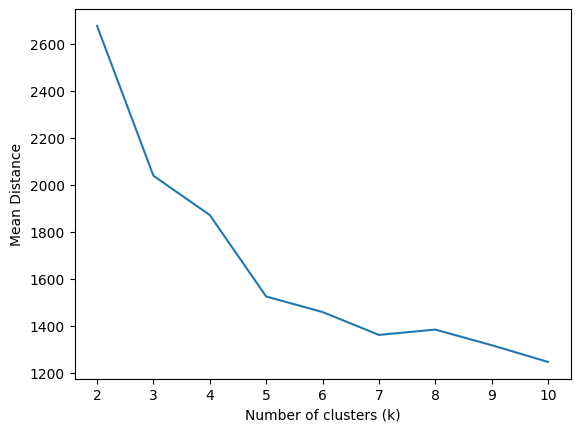

In [11]:
df_fifa_numeric = df_fifa.drop(columns=['FullName', 'PositionRole'])

# scaling
df_fifa_scaled = (df_fifa_numeric - df_fifa_numeric.mean()) / df_fifa_numeric.std()

# All features but FullName and PositionRole and running the K algorithm of k from 2 to 10
mean_distances = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_fifa_scaled)
    mean_distances.append(kmeans.inertia_)

# Plotting the mean distances to find the "elbow"
plt.plot(K_range, mean_distances)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Mean Distance')
plt.show()

### Part 1.2: Run K-Means and interpret the result(20 points)

Run the K-means algorithm with $k = 5$, then add a new column to the original `df_fifa` data frame called `cluster` which has the cluster assignments. **In a markdown cell**, examine the subgroups/clusters in the data and determine what similarities (if any) there are in the specified subgroups. **In a markdown cell** discuss:

- how the clusters separated based on `PositionRole` (which was **not** used in the algorithm)
- how the clusters with similar `PositionRole` values differ based on the `Overall` range

In [49]:
k = 5
kmeans = KMeans(n_clusters=k)
df_fifa['cluster'] = kmeans.fit_predict(df_fifa_scaled)

# prints the dataframe with the new column
df_fifa.head()

position_role = df_fifa.groupby('cluster')['PositionRole'].value_counts()
print(position_role)

# Group by cluster and PositionRole to get mean Overall rating
overall_rating = df_fifa.groupby(['cluster', 'PositionRole'])['Overall'].mean()
print(overall_rating)

cluster  PositionRole
0        Midfield        20
         Backfield        6
         Wing             1
1        Backfield       10
         Midfield         1
2        Goalkeeper      16
3        Forward         16
         Midfield         9
         Wing             6
4        Midfield         6
Name: count, dtype: int64
cluster  PositionRole
0        Backfield       86.000000
         Midfield        86.900000
         Wing            85.000000
1        Backfield       86.800000
         Midfield        89.000000
2        Goalkeeper      87.500000
3        Forward         87.062500
         Midfield        86.555556
         Wing            87.666667
4        Midfield        85.666667
Name: Overall, dtype: float64


$\color{red}{\text{1.2 Markdown explaination}}$

### Part 1.3: Run Hierarchical clustering (20 points)

Repeat the analysis with hierarchical clustering. Use Silhouette Score to select the best cluster number and plot the change of Silhouette Score with the number of clusters. Also plot a dendrogram. Use players' full names as the labels and set the color threshold to show five clusters. 

## Part 2: PCA (45 total points)

In this problem you will use the `df_owl_2018.csv` data set (which you used on the previous homework) to see if conducting PCA with all the numeric features of the data:
- can recover groups/clusters of the data that make sense
- can be combined/reduced so that if we were to continue with a supervised ML algorithm, we may use a reduced feature set (there are over 250 numeric features in this data set, perhaps we could combine them into fewer principal components).

In [8]:
df_owl = pd.read_csv('df_owl_2018.csv')
df_owl.head()

,start_time,match_id,stage,map_type,map_name,player,team,hero,role,Ability Damage Done,...,Ultimates Used,Unscoped Accuracy,Unscoped Hits,Unscoped Shots,Venom Mine Kills,Weapon Accuracy,Weapon Kills,Whole Hog Efficiency,Whole Hog Kills,of Rockets Fired
0,2018-01-11 00:12:00,10223,Overwatch League - Stage 1,PAYLOAD,Dorado,Agilities,Los Angeles Valiant,Genji,Damage,0.0,...,8,0.0,0,0,0,0.273585,0,0.0,0,0.0
1,2018-01-11 00:12:00,10223,Overwatch League - Stage 1,PAYLOAD,Dorado,Danteh,San Francisco Shock,Genji,Damage,0.0,...,1,0.0,0,0,0,0.166667,0,0.0,0,0.0
2,2018-01-11 00:12:00,10223,Overwatch League - Stage 1,PAYLOAD,Dorado,Danteh,San Francisco Shock,Junkrat,Damage,0.0,...,3,0.0,0,0,0,0.137500,0,0.0,0,0.0
3,2018-01-11 00:12:00,10223,Overwatch League - Stage 1,PAYLOAD,Dorado,Danteh,San Francisco Shock,Tracer,Damage,0.0,...,3,0.0,0,0,0,0.327001,0,0.0,0,0.0
4,2018-01-11 00:12:00,10223,Overwatch League - Stage 1,PAYLOAD,Dorado,Envy,Los Angeles Valiant,D.Va,Tank,0.0,...,23,0.0,0,0,0,0.314785,0,0.0,0,0.0


### Part 2.1: Conduct PCA, Plot "maps"/biplots, and discuss (20 points)

Use all the numeric features and conduct PCA with them. Add two columns to the data for the first two principal components (`pca0` and `pca1`) and then plot two biplots with `plotly.express`:

- A plot of `pca0` vs. `pca1` with `hover_data = ['hero']` and color by `role`
- A plot of `pca0` vs. `pca1` with `hover_data = ['role']` and color by `hero`

**In a markdown cell** discuss what the biplots (and thus the PCA) tell you about how the numeric features characterize the data.

### Part 2.2 Loading plots (10 points)

Make a loading plot to show the relationship between features for the first two PCs. To make the plot easier to be read. Only show for the first 20 features will be enough. 

### Part 2.3: Choose the PCs (15 points)

We will now make a decision on how many Principal Components to keep in order to store our Overwatch data in less memory and/or prepare to perform further machine learning with the data. To decide:
- Create a bar plot that shows the percent of variance explained by the **first 10 PCA features**
- Calculate the cumulative percent variance explained by the **first 10 PCA features**

**In a markdown cell**, discuss what you think the plot suggests would be the ideal number of PCs to keep, and then see if that matches up with using a 90% variance explained benchmark to decide.